<a href="https://colab.research.google.com/github/charleslien/osu_beatmap_generator/blob/main/Approximator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transcribed from https://git.mine2.live/DevMiner/osu-api/src/branch/master/src/PathApproximator.ts

In [ ]:
import enum

class PathType(enum.Enum):
  LINEAR = 0
  PERFECT_CURVE = 1
  CATMULL = 2
  BEZIER = 3

In [ ]:
from dataclasses import dataclass
import math
import numpy as np

BEZIER_TOLERANCE = 0.25
CIRCULAR_ARC_TOLERANCE = 0.1
CATMULL_DETAIL = 50

def approximateBezier(control_points):
    output = []
    count = len(control_points)

    if count == 0:
      return output
    
    subdivision_buffer_1 = {}
    subdivision_buffer_2 = {}

    to_flatten = [control_points[:]]
    free_buffers = []

    left_child = subdivision_buffer_2

    while len(to_flatten) > 0:
      parent = to_flatten.pop()

      if rateFlatnessOfBezier(parent):
        # If the control points we currently operate on are sufficiently "flat", we use
        # an extension to De Casteljau's algorithm to obtain a piecewise-linear approximation
        # of the bezier curve represented by our control points, consisting of the same amount
        # of points as there are control points.
        _bezierApproximate(parent, output, subdivision_buffer_1, subdivision_buffer_2, count)

        free_buffers.append(parent)
        continue
      
      # If we do not yet have a sufficiently "flat" (in other words, detailed) approximation we keep
      # subdividing the curve we are currently operating on.
      right_child = free_buffers.pop() if len(free_buffers) > 0 else {}

      subdivideBezier(parent, left_child, right_child, subdivision_buffer_1, count)

      for i in range(count):
        parent[i] = left_child[i]
      
      to_flatten.append(right_child)
      to_flatten.append(parent)
    
    output.append(control_points[-1])

    return output

def approximateCatmull(control_points):
  result = []
  control_points_length = len(control_points)

  for i in range(control_points_length - 1):
    v1 = control_points[i - 1] if i > 0 else control_points[i]
    v2 = control_points[i]
    v3 = control_points[i + 1] if i < control_points_length - 1 else v2 + v2 - v1
    v4 = control_points[i + 2] if i < control_points_length - 2 else v3 + v3 - v2

    for c in range(CATMULL_DETAIL + 1):
      result.append(findCatmullPoint(v1, v2, v3, v4, c / CATMULL_DETAIL))
  
  return result

def approximateCircularArc(control_points):
  a = control_points[0]
  b = control_points[1]
  c = control_points[2]

  a_sq = np.linalg.norm(b - c) ** 2
  b_sq = np.linalg.norm(a - c) ** 2
  c_sq = np.linalg.norm(a - b) ** 2

  # If we have a degenerate triangle where a side-length is almost zero, then give up and fall
  # back to a more numerically stable method.
  if a_sq < 0.003 or b_sq < 0.003 or c_sq < 0.003:
    return []
  
  s = a_sq * (b_sq + c_sq - a_sq)
  t = b_sq * (a_sq + c_sq - b_sq)
  u = c_sq * (a_sq + b_sq - c_sq)

  total = s + t + u

  # If we have a degenerate triangle with an almost-zero size, then give up and fall
  # back to a more numerically stable method.
  if total < 0.003:
    return []
  
  centre = (a * s + b * t + c * u) / total
  d_a = a - centre
  d_c = c - centre

  r = np.linalg.norm(d_a)

  theta_start = math.atan2(d_a[1], d_a[0])
  theta_end = math.atan2(d_c[1], d_c[0])

  while theta_end < theta_start:
    theta_end += 2*math.pi

  dir = 1
  theta_range = theta_end - theta_start

  # Decide in which direction to draw the circle, depending on which side of
  # AC B lies.
  ortho_a_to_c = c - a
  
  ortho_a_to_c = np.array((ortho_a_to_c[1], -ortho_a_to_c[0]))

  if ortho_a_to_c.dot(b - a) < 0:
    dir = -dir
    theta_range = 2 * math.pi - theta_range

  # We select the amount of points for the approximation by requiring the discrete curvature
  # to be smaller than the provided tolerance. The exact angle required to meet the tolerance
  # is: 2 * Math.Acos(1 - TOLERANCE / r)
  # The special case is required for extremely short sliders where the radius is smaller than
  # the tolerance. This is a pathological rather than a realistic case.
  amount_points = (
      2
      if 2 * r <= CIRCULAR_ARC_TOLERANCE
      else max(2, math.ceil(theta_range / (2 * math.acos(1 - CIRCULAR_ARC_TOLERANCE / r))))
  )
  
  output = []
  for i in range(amount_points):
    fract = i / (amount_points - 1)
    theta = theta_start + dir * fract * theta_range

    o = np.array((math.cos(theta), math.sin(theta))) * r

    output.append(centre + o)
  
  return output

def rateFlatnessOfBezier(control_points):
  length = len(control_points)
  for i in range(1, length - 1):
    scale = control_points[i] * 2
    sub = control_points[i - 1] - scale
    total = sub + control_points[i + 1]

    if np.linalg.norm(total) > BEZIER_TOLERANCE * 2:
      return False

  return True

def subdivideBezier(control_points, l, r, subdivision_buffer, count):
  midpoints = subdivision_buffer

  for i in range(count):
    midpoints[i] = control_points[i]
  
  for i in range(count):
    l[i] = midpoints[0]
    r[count - i - 1] = midpoints[count - i - 1]

    for j in range(count - i - 1):
      midpoints[j] = (midpoints[j] + midpoints[j + 1]) / 2

def _bezierApproximate(control_points, output, subdivision_buffer_1, subdivision_buffer_2, count):
  l = subdivision_buffer_1
  r = subdivision_buffer_2

  subdivideBezier(control_points, l, r, subdivision_buffer_1, count)

  for i in range(count - 1):
    l[count + i] = r[i + 1]

  for i in range(1, count - 1):
    index = 2 * i
    p = (l[index - 1] + l[index] * 2 + l[index + 1]) * 0.25

    output.append(p)

def findCatmullPoint(v1, v2, v3, v4, t):
  t2 = t * t
  t3 = t2 * t

  return (0.5 * 
          (2*v2 +
          (-v1 + v3) * t +
          (2*v1 - 5*v2 + 4*v3 - v4) * t2 +
          (-v1 + 3*v2 - 3*v3 + v4) * t3))

def calculatePath(control_points, types):
  if len(control_points) == 0:
    return []
  
  calculated_path = []
  
  vertices = control_points[:]
  
  start = 0

  for i in range(len(control_points)):
    if types[i] == None and i < len(control_points) - 1:
      continue
    
    segment_vertices = vertices[start:i + 1]
    segment_type = types[start] or PathType.Linear

    for t in calculateSubPath(segment_vertices, segment_type):
      if len(calculated_path) == 0 or any(calculated_path[-1] != t):
        calculated_path.append(t)
    
    start = i
  
  return calculated_path

def calculateSubPath(sub_control_points, path_type):
  if path_type == PathType.LINEAR:
    return sub_control_points
  elif path_type == PathType.PERFECT_CURVE and len(sub_control_points) == 3:
    subpath = approximateCircularArc(sub_control_points)
    if len(subpath) > 0:
      return subpath
  elif path_type == PathType.CATMULL:
    return approximateCatmull(sub_control_points)
  
  return approximateBezier(sub_control_points)

In [ ]:
import numpy as np
from scipy import optimize

def getCumulativeLength(calculated_path):
  cumulative_length = [0]
  for i in range(1, len(calculated_path)):
    segment_start = calculated_path[i - 1]
    segment = calculated_path[i] - segment_start

    segment_length = np.linalg.norm(segment)

    cumulative_length.append(cumulative_length[-1] + segment_length)

  return cumulative_length

def getEndPoint(calculated_path, length, cumulative_length = None):
  if cumulative_length is None:
    cumulative_length = getCumulativeLength(calculated_path)

  if length <= 0:
    return calculated_path[-1]

  for i in range(1, len(calculated_path)):
    if cumulative_length[i] > length:
      distance_to_travel = length - cumulative_length[i - 1]
      
      segment_start = calculated_path[i - 1]
      segment = calculated_path[i] - segment_start
      segment = segment / np.linalg.norm(segment)
      return segment_start + segment * distance_to_travel
  
  segment_start = calculated_path[-2]
  segment_end = calculated_path[-1]
  segment = segment_end - segment_start
  segment = segment / np.linalg.norm(segment)
  return segment_end + segment * (length - cumulative_length[-1])

def getCircleWithEndpointsAndLength(start, end, length):
  """
  returns angles, midpoints
  """

  displacement = end - start
  displacement_length = np.linalg.norm(displacement)
  if displacement_length > length:
    return (0, 0), (start + displacement / 2, start + displacement / 2)

  # chord_length / arc_length = 0 -> angle = 2 * pi
  # chord_length / arc_length = 1 -> angle = 0
  angle = optimize.fsolve(angleFromChordAndArcLength, # equation to find root
                           [2 * math.pi * (1 - displacement_length / length)], # starting guess
                           args=(displacement_length, length),
                           fprime=angleFromChordAndArcLengthDerivative)[0]
  angle = abs(angle)
  while angle > 2 * math.pi:
    angle -= 2 * math.pi

  rotated = np.array((displacement[1], -displacement[0]))
  rotated *= (1 - math.cos(angle / 2)) / (2 * math.sin(angle / 2))

  arc_midpoint_1 = start + displacement / 2 + rotated
  arc_midpoint_2 = start + displacement / 2 - rotated

  return ((angle, -angle),
          (arc_midpoint_1, arc_midpoint_2))

def angleFromChordAndArcLength(angle, chord_length, arc_length):
  angle2 = angle * angle
  return (2 * arc_length * arc_length / angle2 * (1 - math.cos(angle)) -
          chord_length * chord_length)

def angleFromChordAndArcLengthDerivative(angle, chord_length, arc_length):
  """
  derivative with respect to radius
  """
  angle2 = angle * angle
  angle3 = angle * angle2
  arc_length2 = arc_length * arc_length
  return (-4 * arc_length2 / angle3 * (1 - math.cos(angle)) +
          2 * arc_length2 / angle2 * math.sin(angle))

In [ ]:
import numpy as np

PATH_COMPARISON_GRANULARITY = 1000

def comparePaths(original, candidates):
  original_path, original_length = original
  num_candidates = len(candidates)
  
  original_cumulative_length = getCumulativeLength(original_path)
  candidate_cumulative_lengths = [getCumulativeLength(candidate) for candidate, _ in candidates]

  scores = [0] * num_candidates
  for i in range(PATH_COMPARISON_GRANULARITY):
    progress = i / PATH_COMPARISON_GRANULARITY
    
    original_point = getEndPoint(original_path,
                                 original_length * progress,
                                 cumulative_length=original_cumulative_length)
    
    for i, (candidate_path, length) in enumerate(candidates):
      point = getEndPoint(candidate_path,
                          length * progress,
                          cumulative_length=candidate_cumulative_lengths[i])
      dist = np.linalg.norm(point - original_point)
      scores[i] += dist * dist
  
  return np.argmin(scores), scores

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 248,270,12456,2,0,B|270:245|270:245|280:217|259:158,1,104,2|0,0:2|1:2,0:0:0:0:
points = calculatePath([np.array((248, 270)), np.array((270, 245)), np.array((280, 217)), np.array((259, 158))], [PathType.BEZIER, PathType.BEZIER, None, None])
curve_length = 104
cumulative_length = getCumulativeLength(points)
end_point = getEndPoint(points, curve_length, cumulative_length=cumulative_length)

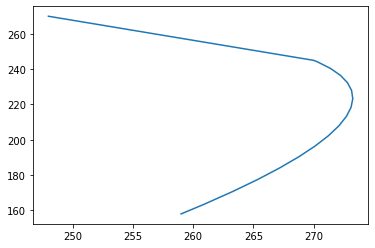

In [ ]:
plt.clf()
plt.plot([p[0] for p in points], [p[1] for p in points])

In [ ]:
(arc_angle_1, arc_angle_2),  (midpoint_1, midpoint_2) = getCircleWithEndpointsAndLength(points[0], end_point, curve_length)

In [ ]:
circle_fit_1 = calculatePath([points[0], midpoint_1, end_point], [PathType.PERFECT_CURVE, None, None])
circle_fit_2 = calculatePath([points[0], midpoint_2, end_point], [PathType.PERFECT_CURVE, None, None])
straight = calculatePath([points[0], end_point], [PathType.LINEAR, None])

cumulative_length_circle_1 = getCumulativeLength(circle_fit_1)
cumulative_length_circle_2 = getCumulativeLength(circle_fit_2)

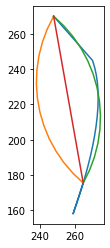

In [ ]:
plt.clf()
plt.plot([p[0] for p in (points + [end_point])], [p[1] for p in (points + [end_point])])
plt.plot([p[0] for p in circle_fit_1], [p[1] for p in circle_fit_1])
plt.plot([p[0] for p in circle_fit_2], [p[1] for p in circle_fit_2])
plt.plot([p[0] for p in straight], [p[1] for p in straight])
plt.gca().set_aspect('equal')

In [ ]:
comparePaths((points, cumulative_length[-1]),
             [(circle_fit_1, cumulative_length_circle_1[-1]),
              (circle_fit_2, cumulative_length_circle_2[-1]),
              (straight, np.linalg.norm(straight[0] - straight[-1]))])

(1, [629510.6052652481, 109556.11682567555, 223140.68886230866])